# Regession

The goal of this notebook is to make a time series regression for annual total days, # events, intensity, duration, severity, etc. at the global scale, regional, country and city level

#### Dependencie

In [84]:
import pandas as pd
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#### Files

In [85]:
DATA_IN = fn = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN = 'All_data20191109_final.csv'
df = pd.read_csv(DATA_IN+FN)

In [86]:
df.columns

Index(['Unnamed: 0', 'CTR_MN_NM', 'Event_ID', 'GCPNT_LAT', 'GCPNT_LON',
       'ID_HDC_G0', 'avg_intensity', 'avg_temp', 'duration', 'event_dates',
       'intensity', 'intermediate-region', 'region', 'sub-region', 'tmax',
       'tot_intensity', 'total_days', 'year', 'start_date'],
      dtype='object')

# What is the slope of the annual average duration over time?

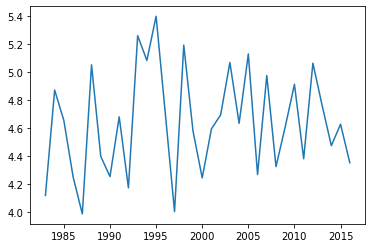

In [87]:
data = df.groupby(['year'])['duration'].mean()
plt.plot(data)

In [89]:
df['severity'] = df['tot_intensity'] * df['duration']


Text(0, 0.5, 'Avg Annual severity')

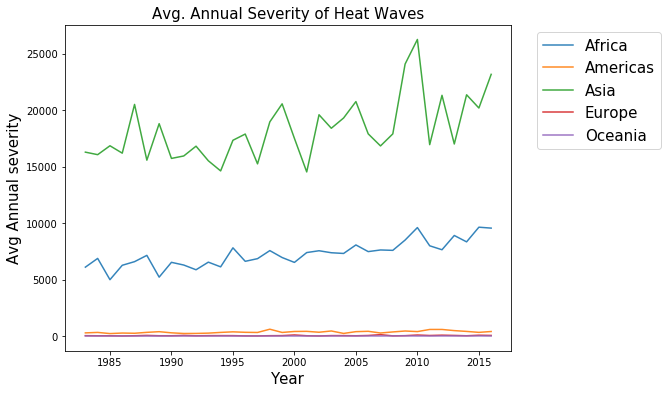

In [115]:
# plot by country 
stat = 'severity'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('region'):
    data = df_c.groupby('year')['ID_HDC_G0'].count()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Avg. Annual Severity of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Avg Annual '+ stat, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

# Plots by each event start data

In [100]:
india = df[df['CTR_MN_NM'] == 'India']

In [108]:
y = india['duration']
x = pd.to_datetime(india['start_date'])

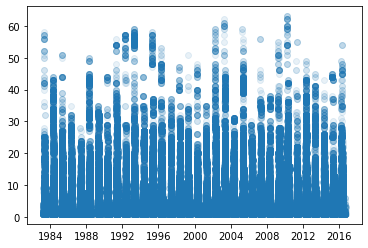

In [111]:
plt.scatter(x,y, alpha = 0.1)

# Regessions

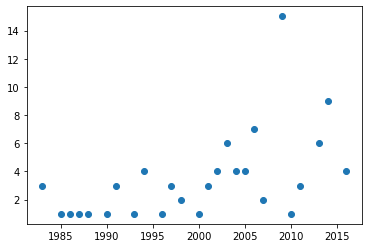

In [162]:
plt.scatter(year, stats)

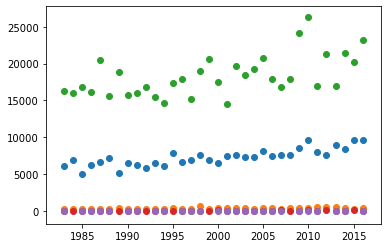

In [164]:
from numpy.polynomial.polynomial import polyfit

regressor = LinearRegression()  


for label, df_c in df.groupby('region'):
    year = np.array(df_c.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    stats = np.array(df_c.groupby('year')['ID_HDC_G0'].count())
    
    plt.scatter(year, stats)
#     regressor.fit(year, stats)
    
#     print(label)
#     print(model.score(year, stats))

In [155]:
stats

array([22697, 23276, 22078, 22730, 27370, 23097, 24430, 22563, 22512,
       22932, 22353, 21108, 25551, 24845, 22424, 27169, 27869, 24523,
       22366, 27495, 26268, 26895, 29246, 25855, 24848, 25866, 33079,
       36358, 25571, 29619, 26449, 30148, 30229, 33193])

In [156]:
regressor = LinearRegression()  
regressor.fit(year, stats) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [157]:
model.score(year, stats)

-52.69221594722377

In [158]:
model.coef_

array([0.00432801])

In [159]:
model.intercept_

-4.0144473981703275